In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from my_utils import filter_feats, get_data
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import SparseCoder
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import json
import numpy as np

In [2]:
def get_selected_features(file_name):
    with open(file_name) as f:
        d = json.load(f)
        train_data = d['train']
        val_data = d['val']
        test_data = d['test']

    X, y = np.array(train_data['X']), np.array(train_data['y'])
    Xv, yv = np.array(val_data['X']), np.array(val_data['y'])
    Xt, yt = np.array(test_data['X']), np.array(test_data['y'])
    
    return X, y, Xv, yv, Xt, yt

In [3]:
X_A, y_A, Xv_A, yv_A, Xt_A, yt_A = get_selected_features('selected_features_A.json')
X_B, y_B, Xv_B, yv_B, Xt_B, yt_B = get_selected_features('selected_features_B.json')
X_C, y_C, Xv_C, yv_C, Xt_C, yt_C = get_selected_features('selected_features_C.json')
X_D, y_D, Xv_D, yv_D, Xt_D, yt_D = get_selected_features('selected_features_D.json')

In [17]:
def test(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(random_state=0, solver='lbfgs',
                             multi_class='auto', max_iter=1000).fit(X_train, y_train)
    lr_score = clf.score(X_test, y_test)

    nn = MLPClassifier(hidden_layer_sizes=(2048), max_iter=1000, activation='logistic')
    nn.fit(X_train, y_train)
    nn_score = nn.score(X_test, y_test)

    D = X_train
    y_v = np.expand_dims(y_test, axis=1)
    T = int(D.shape[1] * 0.1)
    Nt = X_test.shape[0]
    coder = SparseCoder(dictionary=D, transform_n_nonzero_coefs=T, transform_algorithm='omp')
    ds = np.zeros((Nt, 1))
    nc = int(np.max(y_train)) + 1
    for i_t in range(Nt):
        ytest = X_test[i_t, :]
        x_t = coder.transform(ytest.reshape(1, -1))
        e = np.ones((nc, 1))
        for i in range(nc):
            xi = x_t.copy()
            ii = np.argwhere(y_train != i)
            xi[0, ii] = 0
            e[i] = np.linalg.norm(ytest - D.T.dot(xi.T))
        ds[i_t] = np.argmax(e)
    src_score = accuracy_score(ds, y_v)
    
    return [float(f'{lr_score:.3f}'), float(f'{nn_score:.3f}'), float(f'{src_score:.3f}')]

In [27]:
A = [['LR', 'NN', 'SRC'], test(X_A, y_A, Xv_A, yv_A), test(X_A, y_A, Xt_A, yt_A)]
B = [['LR', 'NN', 'SRC'], test(X_B, y_B, Xv_B, yv_B), test(X_B, y_B, Xt_B, yt_B)]
C = [['LR', 'NN', 'SRC'], test(X_C, y_C, Xv_C, yv_C), test(X_C, y_C, Xt_C, yt_C)]
D = [['LR', 'NN', 'SRC'], test(X_D, y_D, Xv_D, yv_D), test(X_D, y_D, Xt_D, yt_D)]

In [28]:
def plot_accuracies(set_acc, set_name):
    labels = set_acc[0]
    val = set_acc[1]
    test = set_acc[2]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, val, width, label='Val')
    rects2 = ax.bar(x + width/2, test, width, label='Test')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy')
    ax.set_title('Classification accuracy of set {}'.format(set_name))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='lower right')
    plt.ylim(0, 1)


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

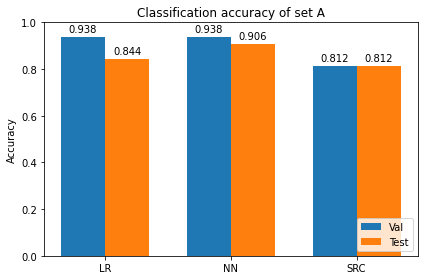

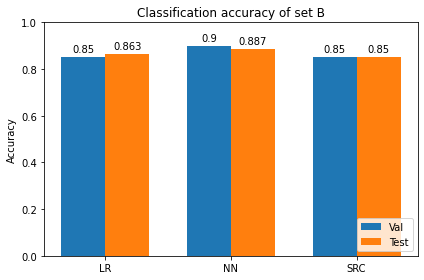

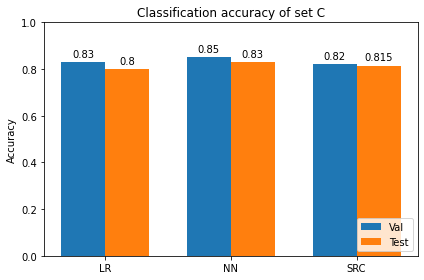

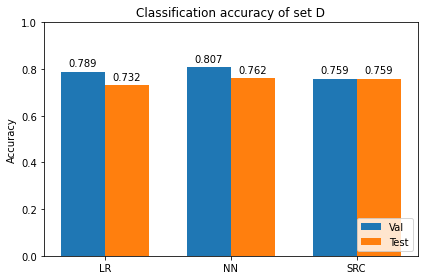

In [29]:
plot_accuracies(A, 'A')
plot_accuracies(B, 'B')
plot_accuracies(C, 'C')
plot_accuracies(D, 'D')